**GRU**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import linear_model
# from d2l import torch as d2l
import torch
import torch.nn as nn
import csv

In [4]:
BCHAIN_MKPRU=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\原始数据\BCHAIN-MKPRU.csv",dtype={"Date":np.str,"Value":np.float64})
LBMA_GOLD=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\原始数据\LBMA-GOLD.csv",dtype={"Date":np.str,"Value":np.float64})
Data=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\处理后数据\C题处理后的中间文件.csv")

C:\Users\rcz\AppData\Local\Temp/ipykernel_36608/4069968976.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  BCHAIN_MKPRU=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\原始数据\BCHAIN-MKPRU.csv",dtype={"Date":np.str,"Value":np.float64})
C:\Users\rcz\AppData\Local\Temp/ipykernel_36608/4069968976.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  LBMA_

In [5]:
def to_timestamp(date):
    return int(time.mktime(time.strptime(date,"%m/%d/%y")))

In [6]:
#将日期变为自然数
start_timestamp=to_timestamp(Data.iloc[0,0])
for i in range(Data.shape[0]):
    Data.iloc[i,0]=(to_timestamp(Data.iloc[i,0])-start_timestamp)/86400
print(Data)

     日期(月/日/年)     比特币价值  是否可以买卖黄金     黄金价值
0          0.0    621.65         1      NaN
1          1.0    609.67         0  1324.60
2          2.0    610.92         0  1323.65
3          3.0    608.82         0  1321.75
4          4.0    610.38         0  1310.80
...        ...       ...       ...      ...
1821    1821.0  51769.06         0  1821.60
1822    1822.0  52677.40         0  1802.15
1823    1823.0  46809.17         0  1786.00
1824    1824.0  46078.38         0  1788.25
1825    1825.0  46368.69         0  1794.60

[1826 rows x 4 columns]


In [7]:
batch_size=1 # 应该只能为1
start_input=30
input_size=Data.shape[0] #训练：通过前input_size天预测input_size+1天，预测：通过2到input_size+1天预测第input_size+2天
hidden_size=20
# input_size=200
output_size=1
layers_size=3
lr=10
num_epochs=1000

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers_size):
        super().__init__()
        self.GRU_layer = nn.GRU(input_size, hidden_size, layers_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.GRU_layer(x)
        x = self.linear(x)
        return x

In [9]:
# 训练过程
device=torch.device("cuda")

gru=GRUModel(30, hidden_size, output_size, layers_size).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(gru.parameters(), lr)

ji=np.array(Data.iloc[0:input_size,3].dropna())
input_size=ji.shape[0]-2

trainB_x=torch.from_numpy(ji[input_size-30:input_size].reshape(-1,batch_size,30)).to(torch.float32).to(device)
trainB_y=torch.from_numpy(ji[input_size].reshape(-1,batch_size,output_size)).to(torch.float32).to(device)

losses = []

for epoch in range(num_epochs):
    output = gru(trainB_x).to(device)
    loss = criterion(output, trainB_y)
    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("loss" + str(epoch) + ":", loss.item())

loss0: 1788.4698486328125
loss1: 1687.276123046875
loss2: 1606.135498046875
loss3: 1516.572998046875
loss4: 1423.166748046875
loss5: 1327.635498046875
loss6: 1230.635498046875
loss7: 1132.729248046875
loss8: 1033.979248046875
loss9: 934.854248046875
loss10: 835.229248046875
loss11: 735.354248046875
loss12: 635.291748046875
loss13: 534.854248046875
loss14: 434.291748046875
loss15: 333.916748046875
loss16: 233.041748046875
loss17: 132.416748046875
loss18: 31.416748046875
loss19: 69.708251953125
loss20: 147.306396484375
loss21: 204.66455078125
loss22: 244.2774658203125
loss23: 268.355712890625
loss24: 278.83056640625
loss25: 277.109619140625
loss26: 264.704833984375
loss27: 242.73583984375
loss28: 212.4326171875
loss29: 174.8873291015625
loss30: 130.4310302734375
loss31: 80.2603759765625
loss32: 24.438720703125
loss33: 35.477783203125
loss34: 79.132080078125
loss35: 107.8218994140625
loss36: 123.4505615234375
loss37: 127.1551513671875
loss38: 119.8074951171875
loss39: 103.3917236328125
lo

In [10]:
# 预测，以比特币为例
# pred_x_train=torch.from_numpy(np.array(Data.iloc[1:input_size+1,1]).reshape(-1,1,input_size)).to(torch.float32).to(device)
pred_x_train=torch.from_numpy(ji[input_size-29:input_size+1]).reshape(-1,1,30).to(torch.float32).to(device)
pred_y_train=gru(pred_x_train).to(device)
print("prediction:",pred_y_train.item())
print("actual:",ji[input_size+1])

prediction: 1793.0419921875
actual: 1794.6


进行到input_size= 30
进行到input_size= 31
进行到input_size= 32
进行到input_size= 33
进行到input_size= 34
进行到input_size= 35
进行到input_size= 36
进行到input_size= 37
进行到input_size= 38
进行到input_size= 39
进行到input_size= 40
进行到input_size= 41
进行到input_size= 42
进行到input_size= 43
进行到input_size= 44
进行到input_size= 45
进行到input_size= 46
进行到input_size= 47
进行到input_size= 48
进行到input_size= 49
进行到input_size= 50
进行到input_size= 51
进行到input_size= 52
进行到input_size= 53
进行到input_size= 54
进行到input_size= 55
进行到input_size= 56
进行到input_size= 57
进行到input_size= 58
进行到input_size= 59
进行到input_size= 60
进行到input_size= 61
进行到input_size= 62
进行到input_size= 63
进行到input_size= 64
进行到input_size= 65
进行到input_size= 66
进行到input_size= 67
进行到input_size= 68
进行到input_size= 69
进行到input_size= 70
进行到input_size= 71
进行到input_size= 72
进行到input_size= 73
进行到input_size= 74
进行到input_size= 75
进行到input_size= 76
进行到input_size= 77
进行到input_size= 78
进行到input_size= 79
进行到input_size= 80
进行到input_size= 81
进行到input_size= 82
进行到input_size= 83
进行到input_size= 84
进行到input_s

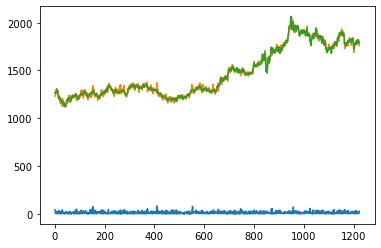

In [11]:
# 预测代码
losses = []
predictions = []
actuals = []
for i in range(start_input, input_size + 1):
    print("进行到input_size=", i)
    # gru=GRUModel(i, hidden_size, output_size, layers_size).to(device)
    gru = GRUModel(30, hidden_size, output_size, layers_size).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(gru.parameters(), lr)

    # 数据，以比特币为例
    trainB_x = torch.from_numpy(ji[i - 30:i].reshape(-1, batch_size, 30)).to(torch.float32).to(device)
    trainB_y = torch.from_numpy(ji[i].reshape(-1, batch_size, output_size)).to(torch.float32).to(device)

    loss = None

    for epoch in range(num_epochs):
        output = gru(trainB_x).to(device)
        loss = criterion(output, trainB_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("loss"+str(epoch)+":", loss.item())
    losses.append(loss.item())

    # 预测，以比特币为例
    pred_x_train = torch.from_numpy(ji[i - 29:i + 1].reshape(-1, 1, 30)).to(torch.float32).to(device)
    pred_y_train = gru(pred_x_train).to(device)
    # print("prediction:",pred_y_train.item())
    # print("actual:",Data.iloc[i+1,1])
    predictions.append(pred_y_train.item())
    actuals.append(ji[i + 1])
plt.plot(losses)

plt.plot(predictions)
plt.plot(actuals)

In [12]:
print(np.array(predictions).shape[0])

1224


In [13]:
print(np.array(actuals).shape[0])

1224


In [14]:
print(input_size-29)

1224


In [ ]:
f=open('2 问题1/周期lstm黄金预测.csv','w',encoding='utf-8',newline="")
csv_writer=csv.writer(f)
csv_writer.writerow(["实际价格","预测价格"])
for i in range(0,input_size-29):
    tmp=[]
    tmp.append(actuals[i])
    tmp.append(round(predictions[i],2))
    csv_writer.writerow(tmp)
f.close()

**回归**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import linear_model
# from d2l import torch as d2l
import torch
import torch.nn as nn
import xlwt

In [2]:
BCHAIN_MKPRU=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\原始数据\BCHAIN-MKPRU.csv",dtype={"Date":np.str,"Value":np.float64})
LBMA_GOLD=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\原始数据\LBMA-GOLD.csv",dtype={"Date":np.str,"Value":np.float64})
Data=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\处理后数据\C题处理后的中间文件.csv")
df = Data

C:\Users\rcz\AppData\Local\Temp/ipykernel_21304/4261364655.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  BCHAIN_MKPRU=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\原始数据\BCHAIN-MKPRU.csv",dtype={"Date":np.str,"Value":np.float64})
C:\Users\rcz\AppData\Local\Temp/ipykernel_21304/4261364655.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  LBMA_

In [3]:
def to_timestamp(date):
    return int(time.mktime(time.strptime(date,"%m/%d/%y")))

In [4]:
#将日期变为自然数
start_timestamp=to_timestamp(Data.iloc[0,0])
for i in range(Data.shape[0]):
    Data.iloc[i,0]=(to_timestamp(Data.iloc[i,0])-start_timestamp)/86400

In [5]:
days_fit=Data.shape[0] # 最小为2

In [6]:
bFit=Data.iloc[0:days_fit,0:2]
gFit=Data.iloc[0:days_fit,0::3].dropna() # 需要考虑NaN的问题

In [7]:
bitcoin_reg=linear_model.LinearRegression()
gold_reg=linear_model.LinearRegression()

In [8]:
bitcoin_reg.fit(np.array(bFit.iloc[:,0]).reshape(-1,1),np.array(bFit.iloc[:,1]).reshape(-1,1))
gold_reg.fit(np.array(gFit.iloc[:,0]).reshape(-1,1),np.array(gFit.iloc[:,1]).reshape(-1,1))

LinearRegression()

In [9]:
print("bitcoin:",bitcoin_reg.predict(np.array([days_fit]).reshape(-1,1)))

bitcoin: [[29568.99959448]]


In [10]:
print("gold:",gold_reg.predict(np.array([days_fit]).reshape(-1,1)))

gold: [[1843.56496063]]


In [11]:
# 预测代码：
b_pred_linear = [None, None]
g_pred_linear = [None, None]
for day_fit in range(2, days_fit + 1):
    # print("进行到day_fit=",day_fit)
    bFit = Data.iloc[0:day_fit, 0:2]
    gFit = Data.iloc[0:day_fit, 0::3].dropna()

    bitcoin_reg = linear_model.LinearRegression()
    gold_reg = linear_model.LinearRegression()

    bitcoin_reg.fit(np.array(bFit.iloc[:, 0]).reshape(-1, 1), np.array(bFit.iloc[:, 1]).reshape(-1, 1))
    gold_reg.fit(np.array(gFit.iloc[:, 0]).reshape(-1, 1), np.array(gFit.iloc[:, 1]).reshape(-1, 1))

    b_pred_linear.append(bitcoin_reg.predict(np.array([day_fit]).reshape(-1, 1)))
    g_pred_linear.append(gold_reg.predict(np.array([day_fit]).reshape(-1, 1)))

In [12]:
ji1=np.array(b_pred_linear).reshape(-1,1)
ji1=np.array(ji1)
ji2=Data.iloc[2:days_fit+1,1]
ji2=np.array(ji2)

C:\Users\rcz\AppData\Local\Temp/ipykernel_21304/3966830884.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ji1=np.array(b_pred_linear).reshape(-1,1)


In [13]:
ji3=[]

for i in range(2,1826):
    ji3.append(round(ji1[i][0][0][0],2))

ji3=np.array(ji3)

In [14]:
print(ji1[3][0][0][0])

603.3499999999999


In [ ]:
book = xlwt.Workbook(encoding="utf-8", style_compression=0)
sheet = book.add_sheet("回归预测比特币", cell_overwrite_ok=True)
col = ("日期","预测值","真实值","误差")  # 元组,如果需要院校简介另加
for i in range(0, 4):
    sheet.write(0, i, col[i])
sheet.write(1,0,"9/11/16")
sheet.write(1,1,621.25)
sheet.write(1,2,621.25)
sheet.write(1,3,0)

sheet.write(2,0,"9/12/16")
sheet.write(2,1,609.67)
sheet.write(2,2,609.67)
sheet.write(2,3,0)
for i in range(0, 1824):
    print("第%d条" % (i + 1))
    sheet.write(i+3,0,df.values[i+2][0])
    sheet.write(i+3,1,ji3[i])
    sheet.write(i+3,2,ji2[i])
    sheet.write(i+3,3,abs(ji3[i]-ji2[i]))
book.save("回归预测比特币.xls")

**时间序列**

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import linear_model
# from d2l import torch as d2l
import torch
import torch.nn as nn

In [ ]:
f=open('lstm比特币预测.csv','w',encoding='utf-8',newline="")
csv_writer=csv.writer(f)
csv_writer.writerow(["实际价格","预测价格"])
for i in range(0,input_size-100+1):
    tmp=[]
    tmp.append(actuals[i])
    tmp.append(round(predictions[i],2))
    csv_writer.writerow(tmp)
f.close()

**灰度预测**

In [16]:
def GM11(x,n):
    '''
    灰色预测
    x：序列，numpy对象
    n:需要往后预测的个数
    '''
    x1 = x.cumsum()#一次累加
    z1 = (x1[:len(x1) - 1] + x1[1:])/2.0#紧邻均值
    z1 = z1.reshape((len(z1),1))
    B = np.append(-z1,np.ones_like(z1),axis=1)
    Y = x[1:].reshape((len(x) - 1,1))
    #a为发展系数 b为灰色作用量
    [[a],[b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Y)#计算参数
    result = (x[0]-b/a)*np.exp(-a*(n-1))-(x[0]-b/a)*np.exp(-a*(n-2))
    S1_2 = x.var()#原序列方差
    e = list()#残差序列
    for index in range(1,x.shape[0]+1):
        predict = (x[0]-b/a)*np.exp(-a*(index-1))-(x[0]-b/a)*np.exp(-a*(index-2))
        e.append(x[index-1]-predict)
    S2_2 = np.array(e).var()#残差方差
    C = S2_2/S1_2#后验差比
    if C<=0.35:
        assess = '后验差比<=0.35，模型精度等级为好'
    elif C<=0.5:
        assess = '后验差比<=0.5，模型精度等级为合格'
    elif C<=0.65:
        assess = '后验差比<=0.65，模型精度等级为勉强'
    else:
        assess = '后验差比>0.65，模型精度等级为不合格'
    #预测数据
    predict = list()
    for index in range(x.shape[0]+1,x.shape[0]+n+1):
        predict.append((x[0]-b/a)*np.exp(-a*(index-1))-(x[0]-b/a)*np.exp(-a*(index-2)))
    predict = np.array(predict)
    return {
            'a':{'value':a,'desc':'发展系数'},
            'b':{'value':b,'desc':'灰色作用量'},
            'predict':{'value':result,'desc':'第%d个预测值'%n},
            'C':{'value':C,'desc':assess},
            'predict':{'value':predict,'desc':'往后预测%d个的序列'%(n)},
            }

In [18]:
# data = np.array([1.2,2.2,3.1,4.5,5.6,6.7,7.1,8.2,9.6,10.6,11,12.4,13.5,14.7,15.2])
# x = data[0:10]#输入数据
# y = data[10:11]#需要预测的数据
# result = GM11(x,len(y))
# predict = result['predict']['value']
# predict = np.round(predict,1)
# print('真实值:',y)
# print('预测值:',predict)
# print(result)


# #首先进行比特币的灰度预测
df=pd.read_csv(r"C:\Users\rcz\Desktop\运筹学\代码及数据\1 数据预处理\处理后数据\C题处理后的中间文件.csv")
train=[]
height,weight=df.shape
# height=10
for i in range(0,height):
    train.append(df.values[i][1])
train=np.array(train)
# print(train)
res=[]
tmp=[]
tmp.append(train[0])
tmp.append(0)
res.append(tmp)
tmp=[]
tmp.append(train[1])
tmp.append(0)
res.append(tmp)
tmp=[]
tmp.append(train[2])
tmp.append(0)
res.append(tmp)
print(res)
for i in range(2,height-1):
    x=train[0:i+1]
    y=train[i+1:i+2]
    result = GM11(x,len(y))
    predict = result['predict']['value']
    predict = np.round(predict,1)
    tmp=[]
    tmp.append(predict[0])
    tmp.append(round(abs(predict[0]-train[i+1]),2))
    # print('真实值:',y)
    # print('预测值:',predict)
    # print(result)
    res.append(tmp)

# #计算误差
# for i in range(0,height):
#     wucha1=abs(res[i]-train[i])
#     wucha.append(wucha1)

# print(1)

[[621.65, 0], [609.67, 0], [610.92, 0]]


In [ ]:
#将其保存在csv文件中终
print(res)
f = open('灰度预测比特币.csv', 'w', encoding='utf-8', newline="")
csv_writer = csv.writer(f)
csv_writer.writerow(["预测结果","误差"])
for i in range(0,height):
    csv_writer.writerow(res[i])
f.close()